# Part 2a — Paragraphs analysis of Hume

## Analysis in this notebook:

After importing and preprocessing, **NMF** is trained on the first section of the book and then applied to each paragraph within the section

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer 
import pandas as pd
from urllib import request
import re

In [4]:
from sklearn.decomposition import NMF

In [5]:
#nltk.download()

This reading in of the main text could be (should be) recoded to load from the dataframe made in `import_books.ipynb`

In [6]:
hume_ECHU = 'https://www.gutenberg.org/cache/epub/9662/pg9662.txt'
url = hume_ECHU
response = request.urlopen(url)

In [7]:
hume_string = response.read().decode('utf8')

In [8]:
len(hume_string)

373361

In [9]:
hume_string.index('SECTION I')

1766

In [10]:
section_1_pos= hume_string.index('SECTION I')
hume_excerpt = hume_string[section_1_pos:4000]
hume_excerpt

'SECTION I.\r\n\r\nOF THE DIFFERENT SPECIES OF PHILOSOPHY.\r\n\r\n\r\n1. Moral philosophy, or the science of human nature, may be treated\r\nafter two different manners; each of which has its peculiar merit, and\r\nmay contribute to the entertainment, instruction, and reformation of\r\nmankind. The one considers man chiefly as born for action; and as\r\ninfluenced in his measures by taste and sentiment; pursuing one object,\r\nand avoiding another, according to the value which these objects seem to\r\npossess, and according to the light in which they present themselves. As\r\nvirtue, of all objects, is allowed to be the most valuable, this species\r\nof philosophers paint her in the most amiable colours; borrowing all\r\nhelps from poetry and eloquence, and treating their subject in an easy\r\nand obvious manner, and such as is best fitted to please the\r\nimagination, and engage the affections. They select the most striking\r\nobservations and instances from common life; place opposit

#### Different ways to remove newlines etc

In [11]:
def remove_pseudo_soft_returns(s):
    s = s.replace('\r\n'*3, '^S ^p ').replace('\r\n'*2, '^p ').replace('\r\n', ' ')
    return s

In [12]:
hume_par = remove_pseudo_soft_returns(hume_string)

In [13]:
hume_par_list = hume_par.split('^p')
hume_par_list

['\ufeffThe Project Gutenberg EBook of An Enquiry Concerning Human Understanding, by  David Hume and L. A. Selby-Bigge',
 ' This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org^S ',
 ' Title: An Enquiry Concerning Human Understanding',
 ' Author: David Hume         L. A. Selby-Bigge',
 ' Posting Date: November 15, 2011 [EBook #9662] Release Date: January, 2006 First Posted: October 14, 2003',
 ' Language: English^S ',
 ' *** START OF THIS PROJECT GUTENBERG EBOOK ENQUIRY CONCERNING HUMAN UNDERSTANDING ***^S ',
 ' ',
 ' Produced by Jonathan Ingram and Project Gutenberg Distributed Proofreaders^S ',
 ' ^S ',
 ' ^S ',
 ' ^S ',
 ' AN ENQUIRY CONCERNING HUMAN UNDERSTANDING.',
 ' BY DAVID HUME^S ',
 '  Extracted from: Enquiries Concerning the Human Understanding, and Concerning the Principles of Mora

In [14]:
hume_echu_par_df = pd.DataFrame(hume_par_list)

In [15]:
hume_echu_par_df.rename(columns = {0:'par_text'}, inplace=True)


In [16]:
hume_echu_par_df.iloc[20:]

,par_text
20,INDEX^S
21,
22,SECTION I.
23,OF THE DIFFERENT SPECIES OF PHILOSOPHY.^S
24,"1. Moral philosophy, or the science of human ..."
...,...
626,Professor Michael S. Hart was the originator ...
627,Project Gutenberg-tm eBooks are often created...
628,Most people start at our Web site which has t...
629,https://www.gutenberg.org


In [17]:
#hume_echu_par_df.iloc[360:400, :]

In [18]:
start_maintext_row = hume_echu_par_df[hume_echu_par_df['par_text'].str.contains('SECTION I.')].index[0]
start_maintext_row


22

In [19]:
end_material_row = hume_echu_par_df[hume_echu_par_df['par_text'].str.contains('INDEX')].index[-1]
end_material_row

378

In [20]:
hume_echu_par_df = hume_echu_par_df.loc[start_maintext_row:end_material_row-1, :]
hume_echu_par_df 

,par_text
22,SECTION I.
23,OF THE DIFFERENT SPECIES OF PHILOSOPHY.^S
24,"1. Moral philosophy, or the science of human ..."
25,2. The other species of philosophers consider...
26,3. It is certain that the easy and obvious ph...
...,...
373,"The sciences, which treat of general facts, a..."
374,"Divinity or Theology, as it proves the existe..."
375,Morals and criticism are not so properly obje...
376,"When we run over libraries, persuaded of thes..."


#### Tokenize

In [21]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [22]:
def sent_tokenize_string_of_text(text): 
    return sent_tokenize(text)
    
sent_toke = sent_tokenize_string_of_text

In [23]:
def word_tokenize_string_of_text(text): 
    return word_tokenize(text)
    
word_toke = word_tokenize_string_of_text

In [24]:
hume_echu_par_df['word_tokenized_par'] = hume_echu_par_df['par_text'].apply(word_toke)

In [25]:
hume_echu_par_df

,par_text,word_tokenized_par
22,SECTION I.,"[SECTION, I, .]"
23,OF THE DIFFERENT SPECIES OF PHILOSOPHY.^S,"[OF, THE, DIFFERENT, SPECIES, OF, PHILOSOPHY.^S]"
24,"1. Moral philosophy, or the science of human ...","[1, ., Moral, philosophy, ,, or, the, science,..."
25,2. The other species of philosophers consider...,"[2, ., The, other, species, of, philosophers, ..."
26,3. It is certain that the easy and obvious ph...,"[3, ., It, is, certain, that, the, easy, and, ..."
...,...,...
373,"The sciences, which treat of general facts, a...","[The, sciences, ,, which, treat, of, general, ..."
374,"Divinity or Theology, as it proves the existe...","[Divinity, or, Theology, ,, as, it, proves, th..."
375,Morals and criticism are not so properly obje...,"[Morals, and, criticism, are, not, so, properl..."
376,"When we run over libraries, persuaded of thes...","[When, we, run, over, libraries, ,, persuaded,..."


### Snowball stemmer

In [26]:
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

def stem_string_of_text(text):
    word_list = [stemmer.stem(w) for w in text.split(' ')]
    return ' '.join(word_list)

# text_string = 'philosophy philosophize philosophical philosopher'
# stem_string_of_text(text_string)

In [27]:
lemma = nltk.stem.WordNetLemmatizer()

def lemmatize_string_of_text(text):
    word_list = [lemma.lemmatize(w) for w in text.split(' ')]
    return ' '.join(word_list)

# text_string = 'principle principles principled'
# lemmatize_string_of_text(text_string)

In [28]:
# text_string = 'philosophy philosophize philosophical philosopher'
# text_string = 'principle principles principled'
# lemmatize_string_of_text(stem_string_of_text(text_string))

In [29]:
hume_echu_par_df['sb_stemmed_par'] = hume_echu_par_df['par_text'].apply(stem_string_of_text)

hume_echu_par_df

,par_text,word_tokenized_par,sb_stemmed_par
22,SECTION I.,"[SECTION, I, .]",section i.
23,OF THE DIFFERENT SPECIES OF PHILOSOPHY.^S,"[OF, THE, DIFFERENT, SPECIES, OF, PHILOSOPHY.^S]",of the differ speci of philosophy.^
24,"1. Moral philosophy, or the science of human ...","[1, ., Moral, philosophy, ,, or, the, science,...","1. moral philosophy, or the scienc of human n..."
25,2. The other species of philosophers consider...,"[2, ., The, other, species, of, philosophers, ...",2. the other speci of philosoph consid man in...
26,3. It is certain that the easy and obvious ph...,"[3, ., It, is, certain, that, the, easy, and, ...",3. it is certain that the easi and obvious ph...
...,...,...,...
373,"The sciences, which treat of general facts, a...","[The, sciences, ,, which, treat, of, general, ...","the sciences, which treat of general facts, a..."
374,"Divinity or Theology, as it proves the existe...","[Divinity, or, Theology, ,, as, it, proves, th...","divin or theology, as it prove the exist of a..."
375,Morals and criticism are not so properly obje...,"[Morals, and, criticism, are, not, so, properl...",moral and critic are not so proper object of ...
376,"When we run over libraries, persuaded of thes...","[When, we, run, over, libraries, ,, persuaded,...","when we run over libraries, persuad of these ..."


In [30]:
# lemmatize_string_of_text("He is wetish. They are very wet. I am wet too. You are wet.")

In [31]:
# hume_echu_par_df=hume_echu_par_df.assign('lemmatized_par' = lambda row: word.lower() for word in row['par_text'].split(' '), axis=1)
hume_echu_par_df['lemmatized_par'] = hume_echu_par_df['par_text'].apply(lemmatize_string_of_text)

hume_echu_par_df

,par_text,word_tokenized_par,sb_stemmed_par,lemmatized_par
22,SECTION I.,"[SECTION, I, .]",section i.,SECTION I.
23,OF THE DIFFERENT SPECIES OF PHILOSOPHY.^S,"[OF, THE, DIFFERENT, SPECIES, OF, PHILOSOPHY.^S]",of the differ speci of philosophy.^,OF THE DIFFERENT SPECIES OF PHILOSOPHY.^S
24,"1. Moral philosophy, or the science of human ...","[1, ., Moral, philosophy, ,, or, the, science,...","1. moral philosophy, or the scienc of human n...","1. Moral philosophy, or the science of human ..."
25,2. The other species of philosophers consider...,"[2, ., The, other, species, of, philosophers, ...",2. the other speci of philosoph consid man in...,2. The other specie of philosopher consider m...
26,3. It is certain that the easy and obvious ph...,"[3, ., It, is, certain, that, the, easy, and, ...",3. it is certain that the easi and obvious ph...,3. It is certain that the easy and obvious ph...
...,...,...,...,...
373,"The sciences, which treat of general facts, a...","[The, sciences, ,, which, treat, of, general, ...","the sciences, which treat of general facts, a...","The sciences, which treat of general facts, a..."
374,"Divinity or Theology, as it proves the existe...","[Divinity, or, Theology, ,, as, it, proves, th...","divin or theology, as it prove the exist of a...","Divinity or Theology, a it prof the existence..."
375,Morals and criticism are not so properly obje...,"[Morals, and, criticism, are, not, so, properl...",moral and critic are not so proper object of ...,Morals and criticism are not so properly obje...
376,"When we run over libraries, persuaded of thes...","[When, we, run, over, libraries, ,, persuaded,...","when we run over libraries, persuad of these ...","When we run over libraries, persuaded of thes..."


In [32]:
hume_echu_par_df

,par_text,word_tokenized_par,sb_stemmed_par,lemmatized_par
22,SECTION I.,"[SECTION, I, .]",section i.,SECTION I.
23,OF THE DIFFERENT SPECIES OF PHILOSOPHY.^S,"[OF, THE, DIFFERENT, SPECIES, OF, PHILOSOPHY.^S]",of the differ speci of philosophy.^,OF THE DIFFERENT SPECIES OF PHILOSOPHY.^S
24,"1. Moral philosophy, or the science of human ...","[1, ., Moral, philosophy, ,, or, the, science,...","1. moral philosophy, or the scienc of human n...","1. Moral philosophy, or the science of human ..."
25,2. The other species of philosophers consider...,"[2, ., The, other, species, of, philosophers, ...",2. the other speci of philosoph consid man in...,2. The other specie of philosopher consider m...
26,3. It is certain that the easy and obvious ph...,"[3, ., It, is, certain, that, the, easy, and, ...",3. it is certain that the easi and obvious ph...,3. It is certain that the easy and obvious ph...
...,...,...,...,...
373,"The sciences, which treat of general facts, a...","[The, sciences, ,, which, treat, of, general, ...","the sciences, which treat of general facts, a...","The sciences, which treat of general facts, a..."
374,"Divinity or Theology, as it proves the existe...","[Divinity, or, Theology, ,, as, it, proves, th...","divin or theology, as it prove the exist of a...","Divinity or Theology, a it prof the existence..."
375,Morals and criticism are not so properly obje...,"[Morals, and, criticism, are, not, so, properl...",moral and critic are not so proper object of ...,Morals and criticism are not so properly obje...
376,"When we run over libraries, persuaded of thes...","[When, we, run, over, libraries, ,, persuaded,...","when we run over libraries, persuad of these ...","When we run over libraries, persuaded of thes..."


In [33]:
par_1 = hume_echu_par_df.iloc[2, :]['sb_stemmed_par']

In [34]:
type(par_1)

str

In [35]:
section_1_df = pd.DataFrame(hume_echu_par_df.iloc[2:19, :])
section_1_df

,par_text,word_tokenized_par,sb_stemmed_par,lemmatized_par
24,"1. Moral philosophy, or the science of human ...","[1, ., Moral, philosophy, ,, or, the, science,...","1. moral philosophy, or the scienc of human n...","1. Moral philosophy, or the science of human ..."
25,2. The other species of philosophers consider...,"[2, ., The, other, species, of, philosophers, ...",2. the other speci of philosoph consid man in...,2. The other specie of philosopher consider m...
26,3. It is certain that the easy and obvious ph...,"[3, ., It, is, certain, that, the, easy, and, ...",3. it is certain that the easi and obvious ph...,3. It is certain that the easy and obvious ph...
27,"4. This also must be confessed, that the most...","[4, ., This, also, must, be, confessed, ,, tha...","4. this also must be confessed, that the most...","4. This also must be confessed, that the most..."
28,"The mere philosopher is a character, which is...","[The, mere, philosopher, is, a, character, ,, ...","the mere philosoph is a character, which is c...","The mere philosopher is a character, which is..."
29,"Man is a reasonable being; and as such, recei...","[Man, is, a, reasonable, being, ;, and, as, su...","man is a reason being; and as such, receiv fr...","Man is a reasonable being; and a such, receiv..."
30,5. Were the generality of mankind contented t...,"[5, ., Were, the, generality, of, mankind, con...",5. were the general of mankind content to pre...,5. Were the generality of mankind contented t...
31,"We may begin with observing, that one conside...","[We, may, begin, with, observing, ,, that, one...","we may begin with observing, that one conside...","We may begin with observing, that one conside..."
32,"Besides, we may observe, in every art or prof...","[Besides, ,, we, may, observe, ,, in, every, a...","besides, we may observe, in everi art or prof...","Besides, we may observe, in every art or prof..."
33,6. Were there no advantage to be reaped from ...,"[6, ., Were, there, no, advantage, to, be, rea...",6. were there no advantag to be reap from the...,6. Were there no advantage to be reaped from ...


In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
vectorizer_stem = CountVectorizer(stop_words='english')
vectorizer_lemma = CountVectorizer(stop_words='english')

In [38]:
vectorizer_stem.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [39]:
type(section_1_df['sb_stemmed_par'])

pandas.core.series.Series

In [40]:

par_word_stem = vectorizer_stem.fit_transform(section_1_df['sb_stemmed_par'])
par_word_stem.shape

(17, 871)

In [41]:
par_word_lemma = vectorizer_lemma.fit_transform(section_1_df['lemmatized_par'])
par_word_lemma.shape

(17, 885)

### Non-negative Matrix Factorization (NMF)

trained on a section, then fit to each paragraph within the section

In [42]:
num_topics = 4

In [43]:
nmf_model_stem = NMF(num_topics )
par_topic_stem = nmf_model_stem.fit_transform(par_word_stem)
par_topic_stem.shape

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(17, 4)

In [44]:
par_topic_stem

array([[0.00000000e+00, 0.00000000e+00, 1.69461056e+00, 6.99116449e-02],
       [6.07654406e-01, 9.86426172e-02, 9.28160991e-01, 0.00000000e+00],
       [2.45314188e-01, 2.54921419e-02, 7.42365034e-01, 3.62917452e-02],
       [9.29321928e-03, 3.72922370e-02, 1.24870021e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.03018514e+00, 0.00000000e+00],
       [4.51996524e-02, 1.06249479e+00, 8.59797447e-01, 3.58919517e-01],
       [2.03290830e-01, 0.00000000e+00, 5.20529130e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.49063745e+00, 1.39398641e-02],
       [4.40099516e-01, 4.60692392e-02, 4.41171930e-01, 0.00000000e+00],
       [1.05055130e-01, 0.00000000e+00, 3.99102358e-01, 6.95896126e-01],
       [2.08444758e-04, 5.73991970e-02, 3.89857139e-01, 5.83314951e-01],
       [0.00000000e+00, 4.09363568e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.42711710e+00],
       [1.18030540e-01, 7.90033888e-02, 2.43657166e

In [45]:
nmf_model_lemma = NMF(num_topics )
par_topic_lemma = nmf_model_lemma.fit_transform(par_word_lemma)
par_topic_lemma.shape


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(17, 4)

In [46]:

topic_word_stem = nmf_model_stem.components_
topic_word_stem.shape

(4, 871)

In [47]:
topic_word_lemma = nmf_model_lemma.components_
topic_word_lemma.shape

(4, 885)

In [48]:
number_of_word_features = 6

from snowball stemming

In [49]:
words_stem = vectorizer_stem.get_feature_names()
topics_stem_indices_sorted = nmf_model_stem.components_.argsort(axis=1)[:, -1:-(number_of_word_features+1):-1]
topic_words_stem = [[words_stem[e] for e in word_list] for word_list in topics_stem_indices_sorted]
topic_words_stem

[['general', 'philosophy', 'attempt', 'care', 'principles', 'principl'],
 ['reason', 'hope', 'abstrus', 'human', 'proper', 'onli'],
 ['life', 'human', 'easi', 'sentiment', 'philosophy', 'everi'],
 ['mind', 'object', 'reflexion', 'distinct', 'power', 'oper']]

In [50]:
#topics_stem

In [51]:
life_human = 'Life of human philosophy over sentiment'
reason_hope = 'Proper reason avoids superstition and the abstruse'
mind_object = 'Distinct parts of the mind as objects of reflexion'
general_philosophy = 'Take care in searching for general principles'

from lemmatization

In [52]:
words_lemma = vectorizer_lemma.get_feature_names()
topics_lemma_indices_sorted = nmf_model_lemma.components_.argsort(axis=1)[:, -1:-(number_of_word_features+1):-1]
topic_words_lemma = [[words_lemma[e] for e in word_list] for word_list in topics_lemma_indices_sorted]
topic_words_lemma

[['principle', 'general', 'philosophy', 'ha', 'principles', 'attempt'],
 ['life', 'human', 'science', 'philosophy', 'philosopher', 'man'],
 ['hope', 'abstruse', 'human', 'proper', 'philosophy', 'superstition'],
 ['mind', 'object', 'reflexion', 'operation', 'power', 'learning']]

Topic **['life', 'human', 'easi', 'sentiment', 'philosophy', 'everi']** for the first 10 sections, 
with a sprinkling of the three other topics. The opening topic is rhetorical appeal to all interests. Then there are focuses on the other topics separately, a return to the original topic in the penultimate paragraph, followed by a topically defuse conclusion.

In [53]:
# par_topic_stem 

In [54]:
(par_topic_stem > .3).astype(int)

array([[0, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 1, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]])

In [55]:
par_topic_stem.T[2, :]

array([1.69461056, 0.92816099, 0.74236503, 1.24870021, 2.03018514,
       0.85979745, 0.52052913, 2.49063745, 0.44117193, 0.39910236,
       0.38985714, 0.        , 0.        , 0.02436572, 0.        ,
       0.34845798, 0.28418359])

In [56]:
pd.DataFrame(topic_words_stem)

,0,1,2,3,4,5
0,general,philosophy,attempt,care,principles,principl
1,reason,hope,abstrus,human,proper,onli
2,life,human,easi,sentiment,philosophy,everi
3,mind,object,reflexion,distinct,power,oper


In [57]:
pd.DataFrame(par_topic_stem.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.607654,0.245314,0.009293,0.000000,0.045200,0.203291,0.000000,0.440100,0.105055,0.000208,0.000000,0.000000,0.118031,3.191554,0.033927,0.222670
1,0.000000,0.098643,0.025492,0.037292,0.000000,1.062495,0.000000,0.000000,0.046069,0.000000,0.057399,4.093636,0.000000,0.079003,0.000000,0.210795,0.259901
2,1.694611,0.928161,0.742365,1.248700,2.030185,0.859797,0.520529,2.490637,0.441172,0.399102,0.389857,0.000000,0.000000,0.024366,0.000000,0.348458,0.284184
3,0.069912,0.000000,0.036292,0.000000,0.000000,0.358920,0.000000,0.013940,0.000000,0.695896,0.583315,0.000000,3.427117,1.909686,0.000000,0.117441,0.000000


In [58]:
df0 = pd.DataFrame({'order':[0, 2, 3, 1]})
df0

,order
0,0
1,2
2,3
3,1


In [59]:
df1 = pd.DataFrame(topic_words_stem)
df2 = pd.DataFrame(par_topic_stem.T)                   
pd.concat([df0, df1, df2], axis=1).sort_values(by='order')

,order,0,1,2,3,4,5,0,1,2,...,7,8,9,10,11,12,13,14,15,16
0,0,general,philosophy,attempt,care,principles,principl,0.000000,0.607654,0.245314,...,0.000000,0.440100,0.105055,0.000208,0.000000,0.000000,0.118031,3.191554,0.033927,0.222670
3,1,mind,object,reflexion,distinct,power,oper,0.069912,0.000000,0.036292,...,0.013940,0.000000,0.695896,0.583315,0.000000,3.427117,1.909686,0.000000,0.117441,0.000000
1,2,reason,hope,abstrus,human,proper,onli,0.000000,0.098643,0.025492,...,0.000000,0.046069,0.000000,0.057399,4.093636,0.000000,0.079003,0.000000,0.210795,0.259901
2,3,life,human,easi,sentiment,philosophy,everi,1.694611,0.928161,0.742365,...,2.490637,0.441172,0.399102,0.389857,0.000000,0.000000,0.024366,0.000000,0.348458,0.284184


In [60]:
par_topic_stem_reordered = pd.concat([df0, df1, df2], axis=1).sort_values(by='order')
par_topic_stem_reordered

,order,0,1,2,3,4,5,0,1,2,...,7,8,9,10,11,12,13,14,15,16
0,0,general,philosophy,attempt,care,principles,principl,0.000000,0.607654,0.245314,...,0.000000,0.440100,0.105055,0.000208,0.000000,0.000000,0.118031,3.191554,0.033927,0.222670
3,1,mind,object,reflexion,distinct,power,oper,0.069912,0.000000,0.036292,...,0.013940,0.000000,0.695896,0.583315,0.000000,3.427117,1.909686,0.000000,0.117441,0.000000
1,2,reason,hope,abstrus,human,proper,onli,0.000000,0.098643,0.025492,...,0.000000,0.046069,0.000000,0.057399,4.093636,0.000000,0.079003,0.000000,0.210795,0.259901
2,3,life,human,easi,sentiment,philosophy,everi,1.694611,0.928161,0.742365,...,2.490637,0.441172,0.399102,0.389857,0.000000,0.000000,0.024366,0.000000,0.348458,0.284184


In [61]:
#temp_df = pd.DataFrame({'topics': topic_labels})
plot_df = par_topic_stem_reordered.iloc[:,(number_of_word_features+1):]
plot_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.607654,0.245314,0.009293,0.000000,0.045200,0.203291,0.000000,0.440100,0.105055,0.000208,0.000000,0.000000,0.118031,3.191554,0.033927,0.222670
3,0.069912,0.000000,0.036292,0.000000,0.000000,0.358920,0.000000,0.013940,0.000000,0.695896,0.583315,0.000000,3.427117,1.909686,0.000000,0.117441,0.000000
1,0.000000,0.098643,0.025492,0.037292,0.000000,1.062495,0.000000,0.000000,0.046069,0.000000,0.057399,4.093636,0.000000,0.079003,0.000000,0.210795,0.259901
2,1.694611,0.928161,0.742365,1.248700,2.030185,0.859797,0.520529,2.490637,0.441172,0.399102,0.389857,0.000000,0.000000,0.024366,0.000000,0.348458,0.284184


In [62]:
#temp_df=pd.concat([temp_df, par_topic_stem_reordered.iloc[:,(number_of_word_features+1):]], axis = 1, ignore_index=True)
#temp_df.rename(columns= {0: 'topics'})

In [63]:
plot_df = plot_df.transpose()
#plot_df.rename(columns='topics_labels')

In [65]:
topic_labels = [general_philosophy, mind_object, reason_hope, life_human]

In [66]:
#plot_df.columns = ['w', 'x', 'y','z'])
plot_df.columns = topic_labels

In [67]:
plot_df.index.name='paragraph'

In [68]:
plot_df

,Take care in searching for general principles,Distinct parts of the mind as objects of reflexion,Proper reason avoids superstition and the abstruse,Life of human philosophy over sentiment
paragraph,,,,
0,0.000000,0.069912,0.000000,1.694611
1,0.607654,0.000000,0.098643,0.928161
2,0.245314,0.036292,0.025492,0.742365
3,0.009293,0.000000,0.037292,1.248700
4,0.000000,0.000000,0.000000,2.030185
5,0.045200,0.358920,1.062495,0.859797
6,0.203291,0.000000,0.000000,0.520529
7,0.000000,0.013940,0.000000,2.490637
8,0.440100,0.000000,0.046069,0.441172


In [69]:
#pd.pivot(par_topic_stem_reordered.iloc[:,(number_of_word_features+1):], columns='topics')

Text(0.5, 1.0, "paragraph topic flow in Hume's Enquiry Concerning Human Understanding, section 1")

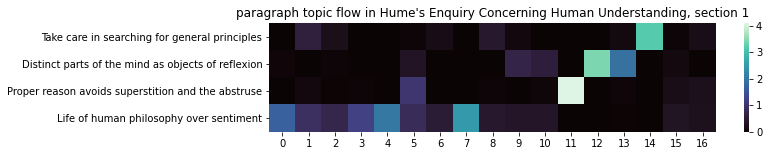

In [94]:
import seaborn as sns
import matplotlib as plt
plt.rcParams["figure.figsize"] = [10, 2]


title_ = 'paragraph topic flow in Hume\'s Enquiry Concerning Human Understanding, section 1'
g = sns.heatmap(par_topic_stem_reordered.iloc[:,(number_of_word_features+1):], cmap='mako', yticklabels=topic_labels)
g.set_title(title_)
#g.savefig(viz_path + title_ + '.svg')
#plt.show()

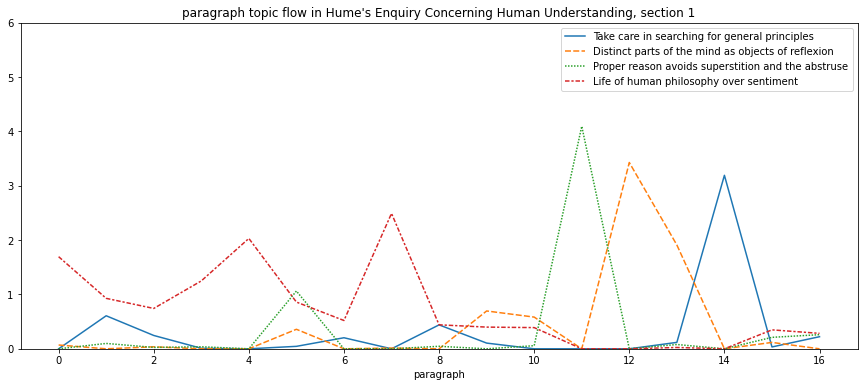

In [72]:
from matplotlib import pyplot as plt
import seaborn as sns
#g = sns.lineplot(par_topic_stem_reordered.iloc[:,(number_of_word_features+1):])
plt.rcParams["figure.figsize"] = [15,6]
g = sns.lineplot(data=plot_df)
g.set(ylim=(0, 6))
#g.savefig(viz_path + 'linegraph_of_'+title_ + '.svg')
g.set_title(title_)

plt.show()


<AxesSubplot:>

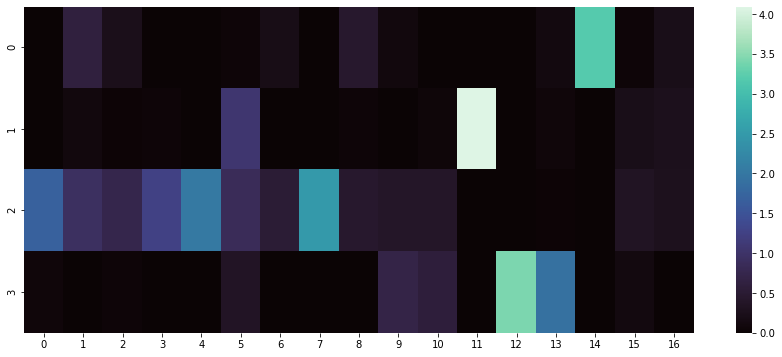

In [73]:

sns.heatmap(par_topic_stem.T, cmap='mako')


In [74]:
###### from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

In [75]:
(par_topic_lemma > .3).astype(int)

array([[0, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0]])

<AxesSubplot:>

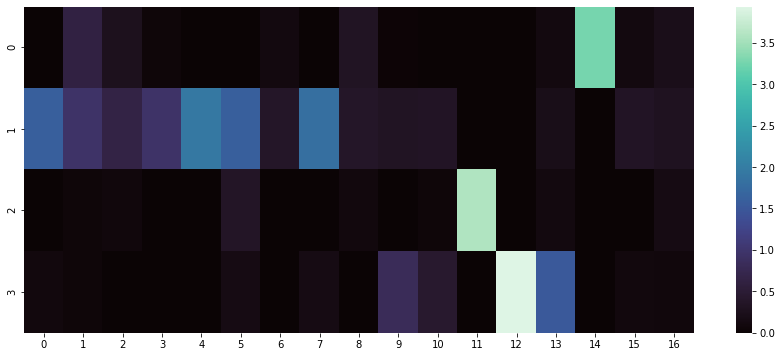

In [76]:
sns.heatmap(par_topic_lemma.T, cmap='mako')

In [77]:
start_row = 2
same_end_as_whitehead = 98
end_of_first_part = 98
end_row = same_end_as_whitehead
section_1_df = pd.DataFrame(hume_echu_par_df.iloc[start_row:end_row+1, :])
section_1_df

,par_text,word_tokenized_par,sb_stemmed_par,lemmatized_par
24,"1. Moral philosophy, or the science of human ...","[1, ., Moral, philosophy, ,, or, the, science,...","1. moral philosophy, or the scienc of human n...","1. Moral philosophy, or the science of human ..."
25,2. The other species of philosophers consider...,"[2, ., The, other, species, of, philosophers, ...",2. the other speci of philosoph consid man in...,2. The other specie of philosopher consider m...
26,3. It is certain that the easy and obvious ph...,"[3, ., It, is, certain, that, the, easy, and, ...",3. it is certain that the easi and obvious ph...,3. It is certain that the easy and obvious ph...
27,"4. This also must be confessed, that the most...","[4, ., This, also, must, be, confessed, ,, tha...","4. this also must be confessed, that the most...","4. This also must be confessed, that the most..."
28,"The mere philosopher is a character, which is...","[The, mere, philosopher, is, a, character, ,, ...","the mere philosoph is a character, which is c...","The mere philosopher is a character, which is..."
...,...,...,...,...
116,The ceremonies of the Roman Catholic religion...,"[The, ceremonies, of, the, Roman, Catholic, re...",the ceremoni of the roman cathol religion may...,The ceremony of the Roman Catholic religion m...
117,42. We may add force to these experiments by ...,"[42, ., We, may, add, force, to, these, experi...",42. we may add forc to these experi by other ...,42. We may add force to these experiment by o...
118,"[8] 'Naturane nobis, inquit, datum dicam,...","[[, 8, ], 'Naturane, nobis, ,, inquit, ,, datu...","[8] naturan nobis, inquit, datum dicam, a...","[8] 'Naturane nobis, inquit, datum dicam,..."
119,_Cicero de Finibus_. Lib. v.,"[_Cicero, de, Finibus_, ., Lib, ., v, .]",_cicero de finibus_. lib. v.,_Cicero de Finibus_. Lib. v.


In [78]:
vectorizer_stem = CountVectorizer(stop_words='english')

In [79]:
par_word_stem = vectorizer_stem.fit_transform(section_1_df['sb_stemmed_par'])
par_word_stem.shape

(97, 2134)

In [80]:
num_topics = 4

In [81]:
nmf_model_stem = NMF(num_topics )
par_topic_stem = nmf_model_stem.fit_transform(par_word_stem)
par_topic_stem.shape

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(97, 4)

In [82]:
topic_word_stem = nmf_model_stem.components_
topic_word_stem.shape

(4, 2134)

In [83]:
topic_labels_words = ['animal, effect, reason, experience, discovovery, cause',
 'sensibility, similar, secret, qualitity, objects, power',
 'idea, mind, ideas, object, differ, everything',
 'human, philosophy, reason, nature, mind, general']

In [84]:
words_stem = vectorizer_stem.get_feature_names()
topics_stem = nmf_model_stem.components_.argsort(axis=1)[:, -1:-7:-1]
topic_words_stem = [[words_stem[e] for e in word_list] for word_list in topics_stem]
topic_words_stem

[['ani', 'effect', 'reason', 'experience', 'discov', 'caus'],
 ['sensibl', 'similar', 'secret', 'qualiti', 'objects', 'power'],
 ['idea', 'mind', 'ideas', 'object', 'differ', 'everi'],
 ['human', 'philosophy', 'reason', 'natur', 'mind', 'general']]

<AxesSubplot:>

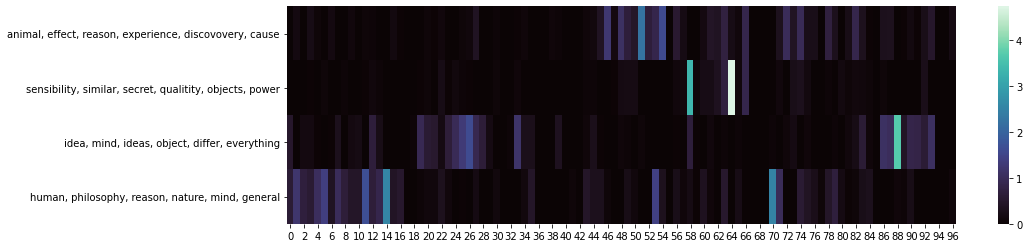

In [85]:
import seaborn as sns
plt.rcParams["figure.figsize"] = [15,4]
sns.heatmap(par_topic_stem.T, cmap='mako', yticklabels=topic_labels_words)

### Trying to model the continuity between consecutive paragraphs in terms of various distance metrics applied to topics
This should be considered again using word2vec instead

In [86]:
from scipy import spatial
#from sklearn.metrics.pairwise import cosine_similarity

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


<AxesSubplot:>

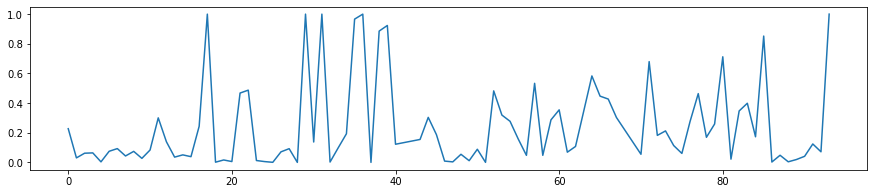

In [87]:
import matplotlib as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,3]
continuity_chronology = [spatial.distance.cosine(par_topic_stem[i,:], par_topic_stem[i+1, :]) for i in range(par_topic_stem.shape[0]-1)]
sns.lineplot(x=range(par_topic_stem.shape[0]-1), y=continuity_chronology)

<AxesSubplot:>

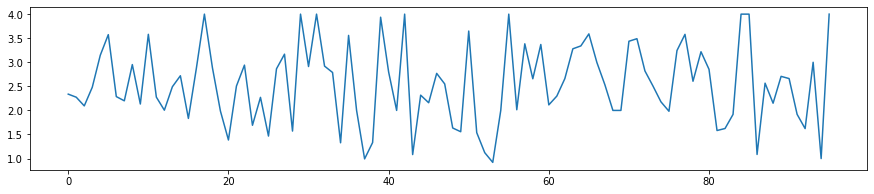

In [88]:

plt.rcParams["figure.figsize"] = [15,3]
continuity_chronology = [spatial.distance.canberra(par_topic_stem[i,:], par_topic_stem[i+1, :]) for i in range(par_topic_stem.shape[0]-1)]
sns.lineplot(x=range(par_topic_stem.shape[0]-1), y=continuity_chronology)

In [89]:
par_word_stem.shape[0]-1

96

[(0.0, 350.0)]

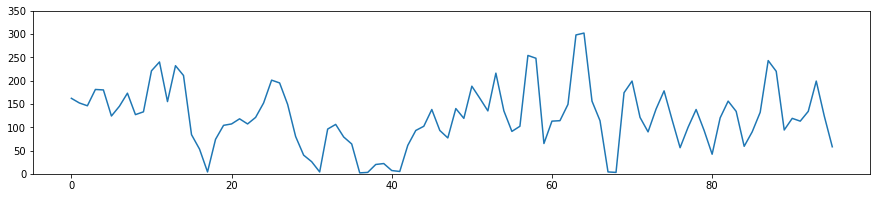

In [90]:
continuity_chronology = [spatial.distance.cityblock(par_word_stem[i,:].todense(), par_word_stem[i+1, :].todense()) for i in range(par_word_stem.shape[0]-1)]

l_plot = sns.lineplot(x=range(par_word_stem.shape[0]-1), y=continuity_chronology)
l_plot.set(ylim=(0, 350))


<AxesSubplot:>

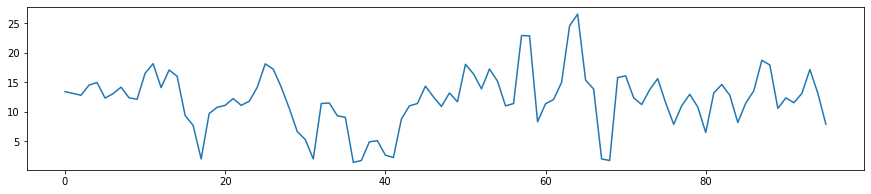

In [91]:
continuity_chronology = [spatial.distance.euclidean(par_word_stem[i,:].todense(), par_word_stem[i+1, :].todense()) for i in range(par_word_stem.shape[0]-1)]
sns.lineplot(x=range(par_word_stem.shape[0]-1), y=continuity_chronology)